In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DEBT_control_class import DEBT_Control_Protocol
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [2]:
np.random.seed(4)
n = 5
params = dict()
params["custom"] = True
params["custom_routes"] = True
C = np.zeros((n, n))
for i in range(n-1):
    C[i, i+1] = 100
    C[n-1, 0] = 100
C = C + C.T
params["capacity_matrix"] = C

In [3]:
def create_path(i, j):
    path = np.zeros((n, n))
    k = i
    while k != j:
        path[k, (k+1) % n] = 1
        k = (k+1) % n
    return path

paths = dict()
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        paths[(i, j)] = [create_path(i, j), create_path(j, i).T]
params["routes"] = paths

In [4]:
demand_params = dict()
demand_params["distribution"] = "deterministic"
demand_params["custom demands"] = True
mean = 10
sparsity = 0.4
demands = np.random.binomial(1, sparsity, (n, n))*np.random.poisson(mean, (n, n))
for i in range(n):
    demands[i,i] = 0
print("Demand Matrix:")
print(demands)
demand_params["demand_matrix"] = demands

Demand Matrix:
[[ 0  0  5 10 11]
 [ 0  0  0  0  0]
 [ 9  0  0  9  0]
 [ 0  0  0  0 15]
 [ 0 10 11 13  0]]


In [5]:
price_params = dict()
price_params["stepsize"] = 0.01
price_params["threshold"] = 5*np.ones((n,n))
price_params["sensitivity"] = 1*np.ones((n,n)) # regularizer coefficient

In [6]:
# initialize the PCN and the protocol
myPCN = DEBT_Control_Protocol(params, demand_params, price_params) 
# loop for T time steps
T = 1001

In [7]:
# create arrays to store flows and prices
flows_data = dict()
path_price_data = dict()
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] == 0:
            continue
        flows_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
        path_price_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
edge_price_data = np.zeros((T, n, n))
reset_data = np.zeros((T, n, n))

In [8]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    myPCN.single_step(t)
    edge_price_data[t] = myPCN.channel_prices.copy()
    for key in flows_data.keys():
        flows_data[key][t] = myPCN.flow_requests[key]
        path_price_data[key][t] = myPCN.path_prices[key]
        reset_data[t] = myPCN.channels_reset
        edge_price_data[t] = myPCN.channel_prices
        logging.info("finished step %d", t)


Flow from A to C : 4.38
Flow from A to D : 0.57
Flow from A to E : 4.07
Flow from C to A : 9.0
Flow from C to D : 5.95
Flow from D to E : 13.26
Flow from E to B : 0.03
Flow from E to C : 10.55
Flow from E to D : 6.74


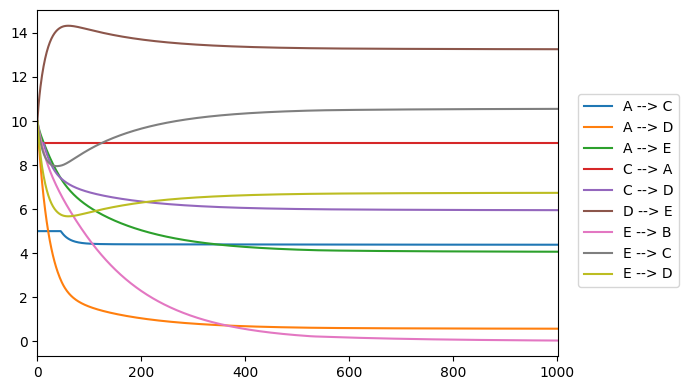

In [9]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            flow = np.zeros(T)
            for k in range(len(myPCN.paths[(i,j)])):
                flow += flows_data[(i,j)][:,k]
            plt.plot(flow, label = alphabets[i] + " --> " + alphabets[j])
            print("Flow from", alphabets[i], "to", alphabets[j], ":", np.round(np.mean(flow[-10:]), 2))
plt.legend(loc=(1.04, 0.2))
plt.xlim([0, T])
plt.tight_layout()

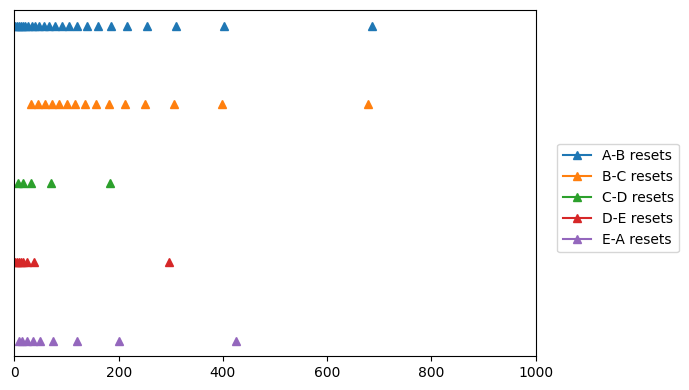

In [10]:
# replace all zeros with nan in reset_data
reset_data[reset_data == 0] = np.nan
plt.figure(figsize=(7,4))
for i in range(n):
    plt.plot(reset_data[:,i, (i+1)%n]*(5-i), label = alphabets[i] + "-" + alphabets[(i+1)%n] + " resets", linestyle=None, marker='^')
    # remove ticks on y-axis
plt.yticks([])
plt.legend(loc=(1.04, 0.3))
plt.xlim([0, T])
plt.tight_layout()

In [11]:
np.nansum(reset_data, axis=(0,1))

array([33., 39., 20., 13., 17.])

In [12]:
demand_params["distribution"] = "Poisson"
myPCN2 = DEBT_Control_Protocol(params, demand_params, price_params) 
# create arrays to store flows and prices
flows_data2 = dict()
path_price_data2 = dict()
for i in range(n):
    for j in range(n):
        if myPCN2.demands[i,j] == 0:
            continue
        flows_data2[(i,j)] = np.zeros((T,len(myPCN2.paths[(i,j)])))
        path_price_data2[(i,j)] = np.zeros((T,len(myPCN2.paths[(i,j)])))
edge_price_data2 = np.zeros((T, n, n))
reset_data2 = np.zeros((T, n, n))

In [13]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    myPCN2.single_step(t)
    edge_price_data2[t] = myPCN2.channel_prices.copy()
    for key in flows_data.keys():
        flows_data2[key][t] = myPCN2.flow_requests[key]
        path_price_data2[key][t] = myPCN2.path_prices[key]
        reset_data2[t] = myPCN2.channels_reset
        edge_price_data2[t] = myPCN2.channel_prices
        logging.info("finished step %d", t)


In [14]:
def smoothen(data, window=10):
    data_smooth = np.convolve(data, np.ones(window)/window, mode='same')
    return data_smooth

Flow from A to C : 4.22
Flow from A to D : 0.54
Flow from A to E : 4.04
Flow from C to A : 9.13
Flow from C to D : 5.33
Flow from D to E : 12.21
Flow from E to B : 0.02
Flow from E to C : 9.86
Flow from E to D : 6.62


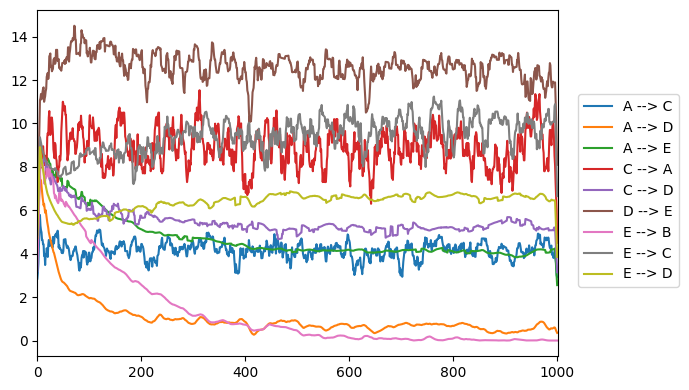

In [15]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN2.demands[i,j] > 0:
            flow = np.zeros(T)
            for k in range(len(myPCN.paths[(i,j)])):
                flow += flows_data2[(i,j)][:,k]
            plt.plot(smoothen(flow, window=10), label = alphabets[i] + " --> " + alphabets[j])
            print("Flow from", alphabets[i], "to", alphabets[j], ":", np.round(np.mean(flow[-100:]), 2))
plt.legend(loc=(1.04, 0.2))
plt.xlim([0, T])
plt.tight_layout()

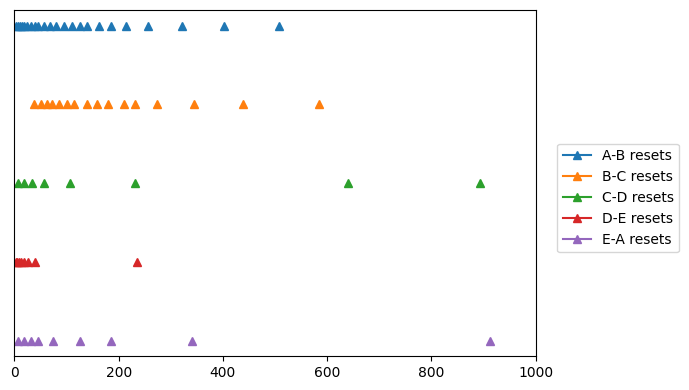

In [16]:
# replace all zeros with nan in reset_data
reset_data2[reset_data2 == 0] = np.nan
plt.figure(figsize=(7,4))
for i in range(n):
    plt.plot(reset_data2[:,i, (i+1)%n]*(5-i), label = alphabets[i] + "-" + alphabets[(i+1)%n] + " resets", linestyle=None, marker='^')
    # remove ticks on y-axis
plt.yticks([])
plt.legend(loc=(1.04, 0.3))
plt.xlim([0, T])
plt.tight_layout()

In [17]:
np.nansum(reset_data2, axis=(0,1))

array([32., 39., 24., 16., 17.])

In [112]:
demand_params["distribution"] = "deterministic"
price_params["stepsize"] = 0.01
T = 1001
myPCN3 = DEBT_Control_Protocol(params, demand_params, price_params) 
# create arrays to store flows and prices
flows_data3 = dict()
path_price_data3 = dict()
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        flows_data3[(i,j)] = np.zeros((T,len(myPCN3.paths[(i,j)])))
        path_price_data3[(i,j)] = np.zeros((T,len(myPCN3.paths[(i,j)])))
edge_price_data3 = np.zeros((T, n, n))
reset_data3 = np.zeros((T, n, n))

In [113]:
print(flows_data3.keys())

dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3)])


In [114]:
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

In [115]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    if t == int(T/2):
        print(myPCN3.demands)
        myPCN3.demands = myPCN3.demands.T
        print(myPCN3.demands)
    myPCN3.single_step(t)
    edge_price_data3[t] = myPCN3.channel_prices.copy()
    for key in flows_data3.keys():
        try:
            flows_data3[key][t] = myPCN3.flow_requests[key]
        except:
            flows_data3[key][t] = 0
        path_price_data3[key][t] = myPCN3.path_prices[key]
        reset_data3[t] = myPCN3.channels_reset
        edge_price_data3[t] = myPCN3.channel_prices
        logging.info("finished step %d", t)


[[ 0  0  5 10 11]
 [ 0  0  0  0  0]
 [ 9  0  0  9  0]
 [ 0  0  0  0 15]
 [ 0 10 11 13  0]]
[[ 0  0  9  0  0]
 [ 0  0  0  0 10]
 [ 5  0  0  0 11]
 [10  0  9  0 13]
 [11  0  0 15  0]]


Flow from A to C : 9.0
Flow from A to D : 0.0
Flow from A to E : 0.0
Flow from C to A : 4.4
Flow from C to D : 0.0
Flow from D to E : 6.55
Flow from E to B : 0.0
Flow from E to C : 0.0
Flow from E to D : 13.45


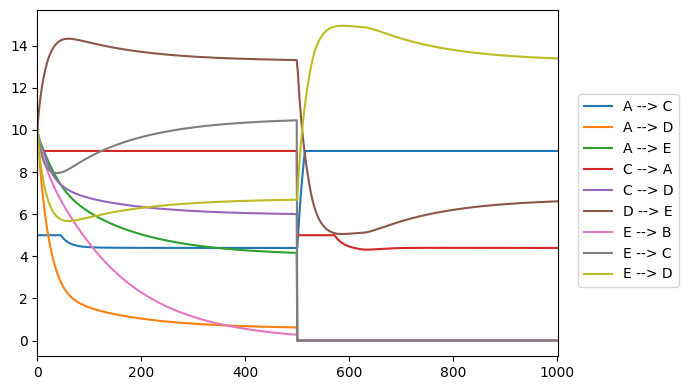

In [116]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN3.demands[j,i] > 0:
            flow = np.zeros(T)
            for k in range(len(myPCN3.paths[(i,j)])):
                flow += flows_data3[(i,j)][:,k]
            plt.plot(flow, label = alphabets[i] + " --> " + alphabets[j])
            print("Flow from", alphabets[i], "to", alphabets[j], ":", np.round(np.mean(flow[-100:]), 2))
plt.legend(loc=(1.04, 0.2))
plt.xlim([0, T])
plt.tight_layout()

Flow from A to C : 9.0
Flow from A to D : 0.0
Flow from A to E : 0.0
Flow from B to E : 0.97
Flow from C to A : 4.4
Flow from C to D : 0.0
Flow from C to E : 10.18
Flow from D to A : 0.77
Flow from D to C : 6.12
Flow from D to E : 6.55
Flow from E to A : 4.47
Flow from E to B : 0.0
Flow from E to C : 0.0
Flow from E to D : 13.45


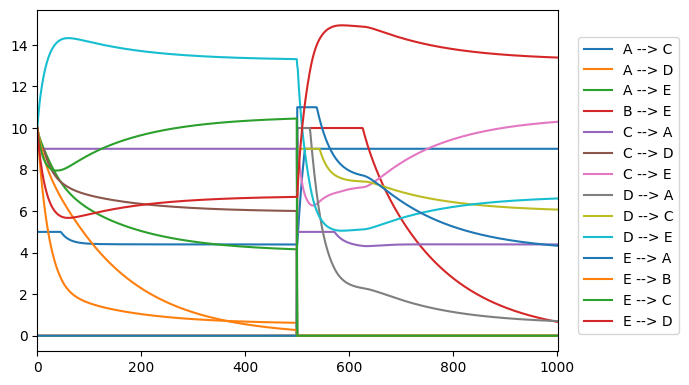

In [117]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN3.demands[j,i] > 0 or myPCN3.demands[i,j] > 0:
            flow = np.zeros(T)
            for k in range(len(myPCN3.paths[(i,j)])):
                flow += flows_data3[(i,j)][:,k]
            plt.plot(flow, label = alphabets[i] + " --> " + alphabets[j])
            print("Flow from", alphabets[i], "to", alphabets[j], ":", np.round(np.mean(flow[-100:]), 2))
plt.legend(loc=(1.04, 0.05))
plt.xlim([0, T])
plt.tight_layout()

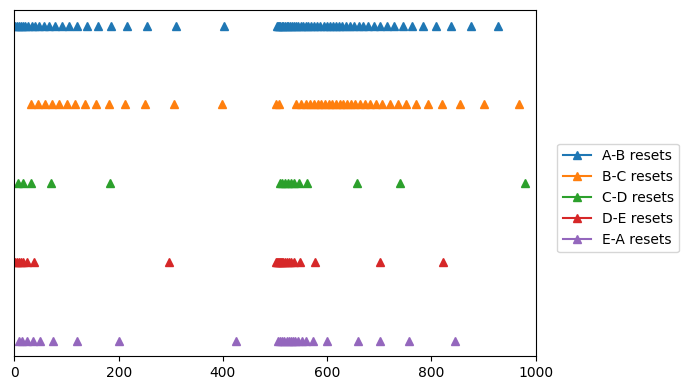

In [118]:
# replace all zeros with nan in reset_data
reset_data3[reset_data3 == 0] = np.nan
plt.figure(figsize=(7,4))
for i in range(n):
    plt.plot(reset_data3[:,i, (i+1)%n]*(5-i), label = alphabets[i] + "-" + alphabets[(i+1)%n] + " resets", linestyle=None, marker='^')
    # remove ticks on y-axis
plt.yticks([])
plt.legend(loc=(1.04, 0.3))
plt.xlim([0, T])
plt.tight_layout()

In [119]:
np.nansum(reset_data3, axis=(0,1))

array([ 96., 115.,  62.,  41.,  52.])

In [120]:
# Flow from A to C : 3.96 (3.93)
# Flow from A to D : 1.4 (1.41)
# Flow from A to E : 3.64 (3.73)
# Flow from C to A : 9.0 (9.11)
# Flow from C to D : 5.36 (4.76)
# Flow from D to E : 13.04 (12.28)
# Flow from E to B : 0.0 (0.02)
# Flow from E to C : 10.41 (9.89)
# Flow from E to D : 6.28 (6.14)

# Flow from A to C : 3.93
# Flow from A to D : 1.41
# Flow from A to E : 3.73
# Flow from C to A : 9.11
# Flow from C to D : 4.76
# Flow from D to E : 12.28
# Flow from E to B : 0.02
# Flow from E to C : 9.89
# Flow from E to D : 6.14